In [2]:
import os, gc, torch
import os 

import numpy as np
import pandas as pd
# from models.load import TrainedModels

from utils.eval import save_iou_results
from utils.engine import xami_evaluate, get_iou_types
from utils.plot import plot_losses, plot_train_val_ap_ars
from models.load import get_trained_model
from utils.coco_eval import get_eval_params_dict
from data.datasets import  OurRadiologsitsDataset, collate_fn
from our_radiologist.load import get_anns
from utils.train import get_optimiser, get_lr_scheduler, print_params_setup
from utils.coco_utils import get_cocos, get_coco_api_from_dataset
from utils.eval import get_ar_ap
from utils.print import print_title
from utils.init import reproducibility, clean_memory_get_device
from data.load import get_datasets, get_dataloaders
from data.constants import XAMI_MIMIC_PATH, DEFAULT_REFLACX_LABEL_COLS
from utils.constants import full_iou_thrs, iou_thrs_5to95
from data.load  import seed_worker, get_dataloader_g
import PIL
from matplotlib.figure import Figure
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm import trange

from typing import Callable, Dict, List, Union, Tuple
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from matplotlib import colors
from utils.pred import pred_thrs_check
from utils.save import get_data_from_metric_logger
from data.datasets import ReflacxDataset, collate_fn
from utils.detect_utils import MetricLogger
from utils.coco_eval import CocoEvaluator, external_summarize
from utils.plot import DISEASE_CMAP, get_legend_elements
from models.train import TrainingInfo
from models.build import create_model_from_setup


## Suppress the assignement warning from pandas.
pd.options.mode.chained_assignment = None  # default='warn

## Supress user warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

%matplotlib inline
# plt.ioff()

In [2]:
device = clean_memory_get_device()
reproducibility()

This notebook will running on device: [CUDA]


In [3]:
from enum import Enum

class TrainedModels(Enum):
    
    # CXR_Clinical_ap = "val_ar_0_9381_ap_0_6945_test_ar_0_8224_ap_0_6378_epoch20_WithClincal_05-16-2022 18-13-10_CXR+Clinical"
    # CXR_Clinical_final = "val_ar_0_9556_ap_0_6776_test_ar_0_7849_ap_0_6534_epoch71_WithClincal_05-16-2022 19-38-03_CXR+Clinical"

    # CXR_ap = "val_ar_0_7518_ap_0_5042_test_ar_0_5388_ap_0_3255_epoch22_WithoutClincal_05-16-2022 20-18-25_CXR"
    # CXR_final = "val_ar_0_5966_ap_0_4046_test_ar_0_5388_ap_0_3893_epoch54_WithoutClincal_05-16-2022 21-10-18_CXR"

    CXR_Clinial="val_ar_0_6160_ap_0_2978_test_ar_0_4945_ap_0_2315_epoch32_WithClincal_05-19-2022 17-45-13_CXR_Clinical"
    CXR="val_ar_0_4734_ap_0_2989_test_ar_0_3947_ap_0_2774_epoch142_WithoutClincal_05-19-2022 00-56-01_CXR"


In [4]:
naming_map = {
    # TrainedModels.with_clinical: "with_clinical_best",
    # TrainedModels.with_clinical_final: "with_clinical_final",
    TrainedModels.CXR: "CXR",
    # TrainedModels.without_clinical_final: "without_clinical_final",
    TrainedModels.CXR_Clinial: "CXR + Clinical"
}


In [5]:
models = []
train_infos = []

for select_model in [
    TrainedModels.CXR,
    TrainedModels.CXR_Clinial,
]:

    model, train_info, _, _ = get_trained_model(
        select_model,
        DEFAULT_REFLACX_LABEL_COLS,
        device,
        rpn_nms_thresh=0.3,
        box_detections_per_img=10,
        box_nms_thresh=0.2,
        rpn_score_thresh=0.0,
        box_score_thresh=0.05,
    )
    model.eval()
    train_info.name = naming_map[select_model]
    models.append(model)
    train_infos.append(train_info)

    # without_clinical_model, without_clinical_train_info, _ = get_trained_model(
    #     TrainedModels.without_clinical,
    #     DEFAULT_REFLACX_LABEL_COLS,
    #     device,
    #     rpn_nms_thresh=0.3,
    #     box_detections_per_img=10,
    #     box_nms_thresh=0.2,
    #     rpn_score_thresh=0.0,
    #     box_score_thresh=0.05,
    # )
    # without_clinical_model.eval()

    # with_clinical_model, with_clinical_train_info, _ = get_trained_model(
    #         TrainedModels.with_clinical,
    #         DEFAULT_REFLACX_LABEL_COLS,
    #         device,
    #         rpn_nms_thresh=0.3,
    #         box_detections_per_img=10,
    #         box_nms_thresh=0.2,
    #         rpn_score_thresh=0.0,
    #         box_score_thresh=0.05,
    # )
    # with_clinical_model.eval()



Load custom model
Using ResNet as backbone
Using pretrained backbone. resnet50
Not using pretrained MaksRCNN model.
Load custom model
Using ResNet as backbone
Using pretrained backbone. resnet50
Using ResNet as clinical backbone
Not using pretrained MaksRCNN model.


In [6]:
from data.transforms import get_transform

dataset_params_dict = {
    "XAMI_MIMIC_PATH": XAMI_MIMIC_PATH,
    "with_clinical": True,
    "dataset_mode": 'unified',
    "bbox_to_mask": False,
    "labels_cols": DEFAULT_REFLACX_LABEL_COLS,
}

detect_eval_dataset, train_dataset, val_dataset, test_dataset = get_datasets(
    dataset_params_dict=dataset_params_dict,
)

train_dataloader, val_dataloader, test_dataloader = get_dataloaders(
    train_dataset, val_dataset, test_dataset, batch_size=4,
)

In [7]:
# clinical_model, clinical_train_info, _ = get_trained_model(
#     TrainedModels.CXR_Clinical_final,
#     DEFAULT_REFLACX_LABEL_COLS,
#     device,
#     rpn_nms_thresh=0.3,
#     box_detections_per_img=10,
#     box_nms_thresh=0.2,
#     rpn_score_thresh=0.0,
#     box_score_thresh=0.05,
# )

# clinical_model.to(device)
# clinical_model.eval()

# n_threads = torch.get_num_threads()
# torch.set_num_threads(1)

# data = next(iter(test_dataloader))
# data = test_dataloader.dataset.prepare_input_from_data(data, device)
# loss_dict, outputs = clinical_model(*data[:-1])

# torch.set_num_threads(n_threads)

In [8]:
# for train_info in train_infos:
#     print(train_info)
#     model_setup = train_info.model_setup
#     model = create_model_from_setup(
#         DEFAULT_REFLACX_LABEL_COLS,
#         model_setup,
#         rpn_nms_thresh=0.3,
#         box_detections_per_img=10,
#         box_nms_thresh=0.2,
#         rpn_score_thresh=0.0,
#         box_score_thresh=0.05,
#     )
#     print_params_setup(model)
#     plot_train_val_ap_ars(train_info.train_ap_ars, train_info.val_ap_ars)
#     plot_losses(train_info.train_data, train_info.val_data)



In [9]:
# use_iobb = True
# iou_thrs = np.array([0.5])
# model = models[0]
# model_setup = train_infos[0].model_setup

# detect_eval_dataset, train_dataset, val_dataset, test_dataset = get_datasets(
#     dataset_params_dict=dataset_params_dict,
# )

# train_dataloader, val_dataloader, test_dataloader = get_dataloaders(
#     train_dataset, val_dataset, test_dataset, batch_size=4,
# )

# train_coco, val_coco, test_coco = get_cocos(
#     train_dataloader, val_dataloader, test_dataloader
# )


# eval_params_dict = get_eval_params_dict(
#     detect_eval_dataset, iou_thrs=iou_thrs, use_iobb=use_iobb,
# )

# iou_types = get_iou_types(model, model_setup)


In [3]:
legend_elements = get_legend_elements(DISEASE_CMAP["solid"])

In [5]:
legend_elements

In [10]:
legend_elements = get_legend_elements(DISEASE_CMAP["solid"])

g_table = None

def plot_result_for_models(
    models: nn.Module,
    train_infos: List[TrainingInfo],
    dataset: ReflacxDataset,
    device: str,
    idx: int,
    legend_elements: List[Line2D],
    disease_cmap=DISEASE_CMAP,
    score_thres: Dict = None,
    roi_head_thrs=None,
) -> Tuple[Figure, Union[Figure, None]]:
    # change all the model to eval mode.

    ## retrieve the data, and transform them into input.

    # this dataset has to be the one with clinical.
    data = collate_fn([dataset[idx]])
    data = dataset.prepare_input_from_data(data, device)
    imgs, clinical_num, clinical_cat, targets = data

    clinical_series = dataset.df.iloc[idx][dataset.clinical_cols]
    clinical_series["gender"] = dataset.encoders_map["gender"].inverse_transform(
        [clinical_series["gender"]]
    )[0]

    ## Get the predictions from all the models.
    preds = []
    for train_info, model in zip(train_infos, models):
        model.eval()
        if roi_head_thrs:
            model.roi_heads.score_thresh = roi_head_thrs
        if train_info.model_setup.use_clinical:
            _, pred = model(imgs, clinical_num, clinical_cat)
        else:
            _, pred = model(imgs)

        if score_thres:
            pred = pred_thrs_check(pred, dataset, score_thres, device)

        preds.append(pred[0])

    bb_fig = plot_bbox_for_models(
        clinical_series,
        targets[0],
        preds,
        train_infos,
        dataset.label_idx_to_disease,
        legend_elements,
        disease_cmap["solid"],
    )

    return bb_fig


def plot_bbox_for_models(
    clinical_series: pd.Series,
    target: List[Dict],
    preds: List[List[Dict]],
    train_infos: List[TrainingInfo],
    label_idx_to_disease: Callable[[int], str],
    legend_elements: List[Line2D],
    disease_color_code_map: Dict[str, str],
) -> Figure:

    fig, axes = plt.subplots(
        1, 3 + len(preds), figsize=((len(preds) + 3) * 10, 10), dpi=120, sharex=True
    )

    fig.suptitle(target["image_path"])

    fig.legend(handles=legend_elements, loc="upper right")

    img = PIL.Image.open(target["image_path"]).convert("RGB")

    # show the image in every matrix.
    for ax in axes[1:]:
        ax.imshow(img)

    # we plot the tabular data over here.
    axes[0].set_title(f"Clinical Data")
    table = axes[0].table(
        cellText=[[v] for v in clinical_series.values],
        rowLabels=clinical_series.index,
        loc="center right",
        colWidths=[0.1, 0.1],
    )
    table.scale(2, 4)
    table.set_fontsize(85)
    axes[0].axis("off")
    # axes[0].axis("tight")

    # plot gt.
    axes[1].set_title(f"Original CXR")

    gt_ax_i = 2
    axes[gt_ax_i].set_title(
        f"Ground Truth ({len(target['boxes'].detach().cpu().numpy())})"
    )

    for label, bbox in zip(
        target["labels"].detach().cpu().numpy(), target["boxes"].detach().cpu().numpy(),
    ):
        disease = label_idx_to_disease(label)
        c = disease_color_code_map[disease]
        axes[gt_ax_i].add_patch(
            Rectangle(
                (bbox[0], bbox[1]),
                bbox[2] - bbox[0],
                bbox[3] - bbox[1],
                fill=False,
                color=c,
                linewidth=2,
            )
        )
        axes[gt_ax_i].text(bbox[0], bbox[1], disease, color="black", backgroundcolor=c)

    # plot pred.
    for i, pred in enumerate(preds):
        ax = axes[i + 3]
        ax.set_title(
            f"{train_infos[i].name} - Predictions ({len(pred['boxes'].detach().cpu().numpy())})"
        )

        # for the predictions. generate the recs, and draw it on fig.
        for label, bbox, score in zip(
            pred["labels"].detach().cpu().numpy(),
            pred["boxes"].detach().cpu().numpy(),
            pred["scores"].detach().cpu().numpy(),
        ):
            disease = label_idx_to_disease(label)
            c = disease_color_code_map[disease]
            ax.add_patch(
                Rectangle(
                    (bbox[0], bbox[1]),
                    bbox[2] - bbox[0],
                    bbox[3] - bbox[1],
                    fill=False,
                    color=c,
                    linewidth=2,
                )
            )
            ax.text(
                bbox[0],
                bbox[1],
                f"{disease} ({score:.2f})",
                color="black",
                backgroundcolor=c,
            )

    # plt.plot()
    # plt.pause(0.01)

    # fig.tight_layout()

    return fig


In [11]:
# fig = plot_result_for_models(
#         models,
#         train_infos,
#         detect_eval_dataset,
#         device,
#         idx=0,
#         legend_elements=legend_elements,
#         disease_cmap=DISEASE_CMAP,
#         roi_head_thrs=0.3,
#     )

 33%|███▎      | 82/245 [04:49<09:35,  3.53s/it]


KeyboardInterrupt: 

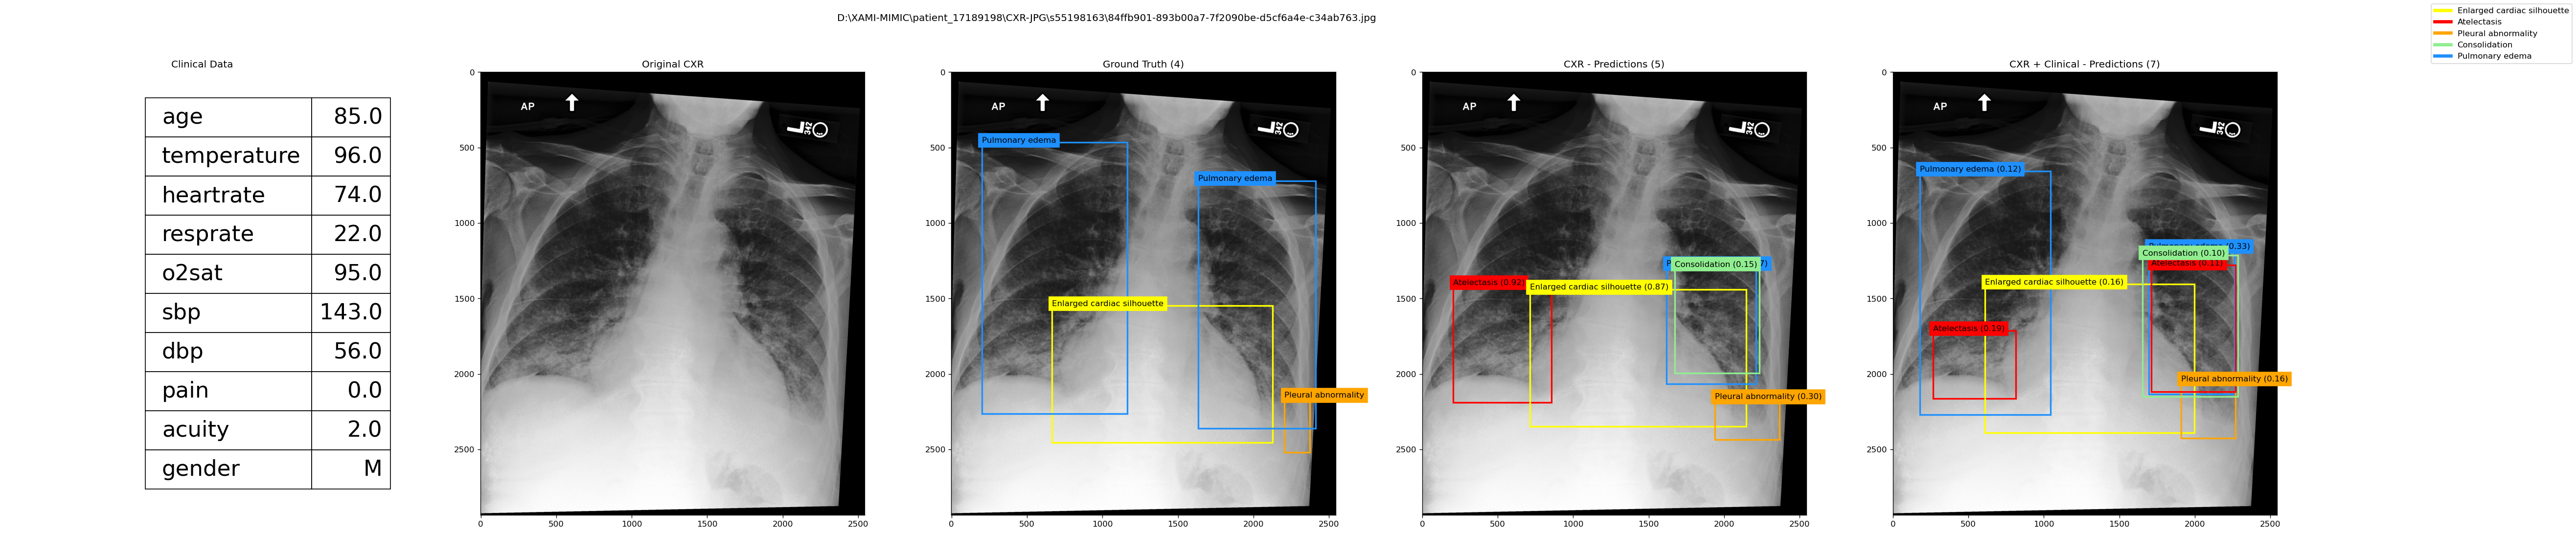

In [12]:
# iou_thrs = 0.05
for iou_thrs in [
    # 0.05,
    0.1,
    # 0.3
]:

    destination_folder = f"generated_bb (thrs={iou_thrs})"

    os.makedirs(destination_folder, exist_ok=True)
    os.makedirs(os.path.join(destination_folder, "train"), exist_ok=True)
    os.makedirs(os.path.join(destination_folder, "val"), exist_ok=True)
    os.makedirs(os.path.join(destination_folder, "test"), exist_ok=True)

    for idx in trange(345, len(detect_eval_dataset)):
        fig = plot_result_for_models(
            models,
            train_infos,
            detect_eval_dataset,
            device,
            idx=idx,
            legend_elements=legend_elements,
            disease_cmap=DISEASE_CMAP,
            roi_head_thrs=iou_thrs,
        )
        instance = detect_eval_dataset.df.iloc[idx]
        fig.savefig(
            os.path.join(
                destination_folder,
                instance["split"],
                f"{instance['dicom_id']} ({idx}).png",
            )
        )
        plt.cla()
        plt.clf()
        plt.close("all")



In [ ]:
# fig = plot_result_for_models(
#     models,
#     train_infos,
#     detect_eval_dataset,
#     device,
#     idx=idx,
#     legend_elements=legend_elements,
#     disease_cmap=DISEASE_CMAP,
#     roi_head_thrs=0.3,
# )
# instance = detect_eval_dataset.df.iloc[idx]
# # fig.savefig(os.path.join("generated_bb", instance['split'], f"{instance['dicom_id']} ({idx}).png"))
# # plt.close('all')

In [ ]:
idx

345